# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [122]:
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
import numpy as np
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

### Change directory

In [123]:
import os
CUR_DIR = os.getcwd()

### Load the training data from train.csv file

In [124]:
import csv
TRAIN_CSV = "train_labels.csv"
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3 

EPOCHS = 10 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.

In [125]:
with open(TRAIN_CSV,'r') as f:
    with open("updated_train_labels.csv",'w') as f1:
        next(f) # skip header line
        for line in f:
            f1.write(line)
            
TRAIN_CSV = "updated_train_labels.csv"

### Print the shape of the train dataset

In [126]:
data = np.genfromtxt("updated_train_labels.csv", delimiter=',', names=True)

In [127]:
table = data.view(np.float64).reshape(len(data), -1)

In [128]:
table.shape

(172, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [129]:
IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3 

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [130]:
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile), 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    

    for col, row in enumerate(reader):
               
        for i, r in enumerate(row[1:8]): # Parse row with seven entities
            if(i != 2):
                row[i+1] = int(r)
            
              
        path, image_width, image_height, class_1, x0, y0, x1, y1= row  
        
#         path = "./" + path.split('/')[-2] + "/" + path.split('/')[-1]
        coords[col, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
        coords[col, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col, 3] = (y1 - y0) * IMAGE_SIZE / image_height
        paths.append(path)



### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [131]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

for i, f in enumerate(paths):
    f1 = CUR_DIR + "/images/" + f
    img = Image.open(f1) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [132]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

In [133]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

### Define a custom loss function IoU which calculates Intersection Over Union

In [134]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [135]:
gt.shape

(173, 8)

In [136]:
gt = coords

model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
#                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
#stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit(batch_images,gt,
            epochs=10,batch_size = 32,
            verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
173/173 [==============================] - 4s 21ms/step - loss: 2897.9919 - IoU: 0.0700
Epoch 2/10
173/173 [==============================] - 2s 14ms/step - loss: 715.4443 - IoU: 0.4236
Epoch 3/10
173/173 [==============================] - 2s 14ms/step - loss: 600.5911 - IoU: 0.5368
Epoch 4/10
173/173 [==============================] - 2s 14ms/step - loss: 592.8522 - IoU: 0.5313
Epoch 5/10
173/173 [==============================] - 2s 14ms/step - loss: 349.9208 - IoU: 0.6068
Epoch 6/10
173/173 [==============================] - 2s 14ms/step - loss: 281.5938 - IoU: 0.5839
Epoch 7/10
173/173 [==============================] - 3s 19ms/step - loss: 239.5132 - IoU: 0.6056
Epoch 8/10
173/173 [==============================] - 3s 15ms/step - loss: 192.6413 - IoU: 0.6577
Epoch 9/10
173/173 [==============================] - 2s 14ms/step - loss: 169.4443 - IoU: 0.6926
Epoch 10/10
173/173 [==============================] - 2s 14ms/step -

### Pick a test image from the given data

In [137]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
import cv2
filename = './images/raccoon-200.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [138]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [139]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

In [140]:
print(region)

[ 39.31236    4.60916   70.708466 102.31751 ]


### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [142]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)




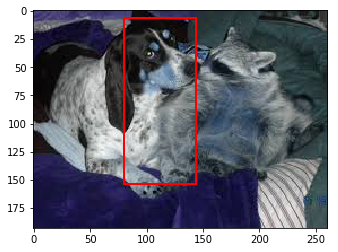

In [143]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

#### Change your present working directory

In [185]:
print(os.getcwd())

/Users/ashishsingh/AIML/Assignments/R9_InternalLab


### Load your data file

In [186]:
import pandas as pd

In [187]:
df = pd.read_csv('/Users/ashishsingh/AIML/Assignments/R9_InternalLab/daily-minimum-temperatures-in-me.csv', index_col='Date')
print(df.head())


            Temperature
Date                   
1981-01-01         20.7
1981-01-02         17.9
1981-01-03         18.8
1981-01-04         14.6
1981-01-05         15.8


#### Plot data

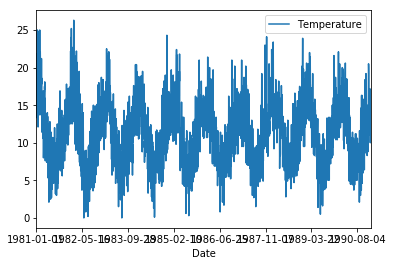

In [188]:
df.plot()

#### Descibe your dataframe

In [189]:
df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [190]:
df.isnull().sum()

Temperature    0
dtype: int64

No null values

#### Drop null values

No Null values so nothing to drop
#df.dropna(inplace=True)

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a4ae03978>]],
      dtype=object)

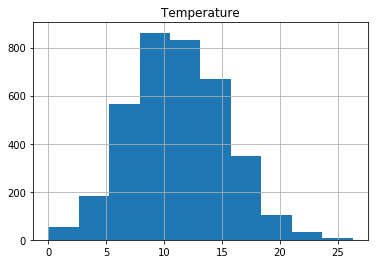

In [191]:
df.hist(bins=10)

#### Check the maximum and minimum values

In [192]:
# Scaled Data
print('Min', np.min(df))
print('Max', np.max(df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [193]:
df.columns

Index(['Temperature'], dtype='object')

In [194]:
df['Temperature'] = df['Temperature']/100 #normalize the data

In [206]:
df.dtypes

Temperature    float64
dtype: object

In [207]:
dataset = df.astype('float32')

In [205]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

/Users/ashishsingh/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


#### Check the maximum and minimum values of scaled data

In [208]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [209]:
print(scaled[:10])

[[0.78707222]
 [0.68060835]
 [0.71482884]
 [0.55513305]
 [0.60076046]
 [0.60076046]
 [0.60076046]
 [0.66159691]
 [0.82889728]
 [0.76045625]]


### Split data into Training and Testing

In [210]:
#Create the model
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


#### Print train and test size

In [211]:
print(train_size)

2555


In [212]:
print(test_size)

3650


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [213]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [214]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.78707222]
Y 1
0.680608354893745
1
X 1 to 2
[0.68060835]
Y 2
0.7148288417571539
2
X 2 to 3
[0.71482884]
Y 3
0.555133047533229
3
X 3 to 4
[0.55513305]
Y 4
0.6007604577817827
4
X 4 to 5
[0.60076046]
Y 5
0.6007604577817827
5
X 5 to 6
[0.60076046]
Y 6
0.6007604577817827
6
X 6 to 7
[0.60076046]
Y 7
0.6615969103491789
7
X 7 to 8
[0.66159691]
Y 8
0.8288972823909303
8
X 8 to 9
[0.82889728]
Y 9
0.7604562520057075
9
X 9 to 10
[0.76045625]
Y 10
0.6159695567590304
10
X 10 to 11
[0.61596956]
Y 11
0.5057034050341673
11
X 11 to 12
[0.50570341]
Y 12
0.6349809446451915
12
X 12 to 13
[0.63498094]
Y 13
0.8174904723225958
13
X 13 to 14
[0.81749047]
Y 14
0.9505703008425331
14
X 14 to 15
[0.9505703]
Y 15
0.787072217709695
15
X 15 to 16
[0.78707222]
Y 16
0.7832699288007818
16
X 16 to 17
[0.78326993]
Y 17
0.9429657230247067
17
X 17 to 18
[0.94296572]
Y 18
0.6730037770759186
18
X 18 to 19
[0.67300378]
Y 19
0.5893535910550429
19
X 19 to 20
[0.58935359]
Y 20
0.6920151649620796
20
X 20 to 21
[

0.384030414911767
472
X 472 to 473
[0.38403041]
Y 473
0.2813688126755277
473
X 473 to 474
[0.28136881]
Y 474
0.3269961945948788
474
X 474 to 475
[0.32699619]
Y 475
0.29657793998197807
475
X 475 to 476
[0.29657794]
Y 476
0.3460075824810398
476
X 476 to 477
[0.34600758]
Y 477
0.4942965383074276
477
X 477 to 478
[0.49429654]
Y 478
0.6273764234857702
478
X 478 to 479
[0.62737642]
Y 479
0.4904942493985144
479
X 479 to 480
[0.49049425]
Y 480
0.26235739646016415
480
X 480 to 481
[0.2623574]
Y 481
0.26235739646016415
481
X 481 to 482
[0.2623574]
Y 482
0.33079845517458945
482
X 482 to 483
[0.33079846]
Y 483
0.3802281260028538
483
X 483 to 484
[0.38022813]
Y 484
0.4106463806157545
484
X 484 to 485
[0.41064638]
Y 485
0.285171101584441
485
X 485 to 486
[0.2851711]
Y 486
0.2395437196650899
486
X 486 to 487
[0.23954372]
Y 487
0.45247147362619233
487
X 487 to 488
[0.45247147]
Y 488
0.5247147929203283
488
X 488 to 489
[0.52471479]
Y 489
0.44866918471727907
489
X 489 to 490
[0.44866918]
Y 490
0.4182509

[0.42585551]
Y 859
0.5133079828519937
859
X 859 to 860
[0.51330798]
Y 860
0.4904942493985144
860
X 860 to 861
[0.49049425]
Y 861
0.2585551358804535
861
X 861 to 862
[0.25855514]
Y 862
0.3802281260028538
862
X 862 to 863
[0.38022813]
Y 863
0.5513307586243158
863
X 863 to 864
[0.55133076]
Y 864
0.44486689580836586
864
X 864 to 865
[0.4448669]
Y 865
0.25475284697154027
865
X 865 to 866
[0.25475285]
Y 866
0.17490493569497653
866
X 866 to 867
[0.17490494]
Y 867
0.18631177409251365
867
X 867 to 868
[0.18631177]
Y 868
0.2813688126755277
868
X 868 to 869
[0.28136881]
Y 869
0.3155893278681391
869
X 869 to 870
[0.31558933]
Y 870
0.285171101584441
870
X 870 to 871
[0.2851711]
Y 871
0.23574143075617668
871
X 871 to 872
[0.23574143]
Y 872
0.29657793998197807
872
X 872 to 873
[0.29657794]
Y 873
0.501901116125254
873
X 873 to 874
[0.50190112]
Y 874
0.45247147362619233
874
X 874 to 875
[0.45247147]
Y 875
0.2471482691537138
875
X 875 to 876
[0.24714827]
Y 876
0.3155893278681391
876
X 876 to 877
[0.3155

Y 1305
0.26615968536907736
1305
X 1305 to 1306
[0.26615969]
Y 1306
0.3802281260028538
1306
X 1306 to 1307
[0.38022813]
Y 1307
0.403041802797928
1307
X 1307 to 1308
[0.4030418]
Y 1308
0.437262346319742
1308
X 1308 to 1309
[0.43726235]
Y 1309
0.38783267549147765
1309
X 1309 to 1310
[0.38783268]
Y 1310
0.4220532190132916
1310
X 1310 to 1311
[0.42205322]
Y 1311
0.41825093010437836
1311
X 1311 to 1312
[0.41825093]
Y 1312
0.3384030329924159
1312
X 1312 to 1313
[0.33840303]
Y 1313
0.37642583709394056
1313
X 1313 to 1314
[0.37642584]
Y 1314
0.44486689580836586
1314
X 1314 to 1315
[0.4448669]
Y 1315
0.44106460689945265
1315
X 1315 to 1316
[0.44106461]
Y 1316
0.34220532190132913
1316
X 1316 to 1317
[0.34220532]
Y 1317
0.2395437196650899
1317
X 1317 to 1318
[0.23954372]
Y 1318
0.33079845517458945
1318
X 1318 to 1319
[0.33079846]
Y 1319
0.32319390568596557
1319
X 1319 to 1320
[0.32319391]
Y 1320
0.32319390568596557
1320
X 1320 to 1321
[0.32319391]
Y 1321
0.304182489470602
1321
X 1321 to 1322
[0.30

[0.13688212]
Y 1693
0.21673002870541436
1693
X 1693 to 1694
[0.21673003]
Y 1694
0.403041802797928
1694
X 1694 to 1695
[0.4030418]
Y 1695
0.26235739646016415
1695
X 1695 to 1696
[0.2623574]
Y 1696
0.3802281260028538
1696
X 1696 to 1697
[0.38022813]
Y 1697
0.3726235481850273
1697
X 1697 to 1698
[0.37262355]
Y 1698
0.2737642348577013
1698
X 1698 to 1699
[0.27376423]
Y 1699
0.3992395138890148
1699
X 1699 to 1700
[0.39923951]
Y 1700
0.13688211742885065
1700
X 1700 to 1701
[0.13688212]
Y 1701
0.201520901398964
1701
X 1701 to 1702
[0.2015209]
Y 1702
0.31939161677705236
1702
X 1702 to 1703
[0.31939162]
Y 1703
0.3916349644003909
1703
X 1703 to 1704
[0.39163496]
Y 1704
0.30038022889089133
1704
X 1704 to 1705
[0.30038023]
Y 1705
0.32319390568596557
1705
X 1705 to 1706
[0.32319391]
Y 1706
0.30038022889089133
1706
X 1706 to 1707
[0.30038023]
Y 1707
0.304182489470602
1707
X 1707 to 1708
[0.30418249]
Y 1708
0.3726235481850273
1708
X 1708 to 1709
[0.37262355]
Y 1709
0.25475284697154027
1709
X 1709 to 

Y 2156
0.42585550792220483
2156
X 2156 to 2157
[0.42585551]
Y 2157
0.4790874393301798
2157
X 2157 to 2158
[0.47908744]
Y 2158
0.285171101584441
2158
X 2158 to 2159
[0.2851711]
Y 2159
0.41825093010437836
2159
X 2159 to 2160
[0.41825093]
Y 2160
0.5513307586243158
2160
X 2160 to 2161
[0.55133076]
Y 2161
0.7034220316888193
2161
X 2161 to 2162
[0.70342203]
Y 2162
0.5855513021461297
2162
X 2162 to 2163
[0.5855513]
Y 2163
0.4980988272163408
2163
X 2163 to 2164
[0.49809883]
Y 2164
0.6197718456679436
2164
X 2164 to 2165
[0.61977185]
Y 2165
0.768060829823534
2165
X 2165 to 2166
[0.76806083]
Y 2166
0.437262346319742
2166
X 2166 to 2167
[0.43726235]
Y 2167
0.47148286151235336
2167
X 2167 to 2168
[0.47148286]
Y 2168
0.41444864119546515
2168
X 2168 to 2169
[0.41444864]
Y 2169
0.48288972823909304
2169
X 2169 to 2170
[0.48288973]
Y 2170
0.4638783120237294
2170
X 2170 to 2171
[0.46387831]
Y 2171
0.47148286151235336
2171
X 2171 to 2172
[0.47148286]
Y 2172
0.3726235481850273
2172
X 2172 to 2173
[0.372623

[0.41064638]
Y 2520
0.437262346319742
2520
X 2520 to 2521
[0.43726235]
Y 2521
0.3802281260028538
2521
X 2521 to 2522
[0.38022813]
Y 2522
0.5285170818292415
2522
X 2522 to 2523
[0.52851708]
Y 2523
0.517110271760907
2523
X 2523 to 2524
[0.51711027]
Y 2524
0.45247147362619233
2524
X 2524 to 2525
[0.45247147]
Y 2525
0.4220532190132916
2525
X 2525 to 2526
[0.42205322]
Y 2526
0.3117870672884284
2526
X 2526 to 2527
[0.31178707]
Y 2527
0.35741442087857694
2527
X 2527 to 2528
[0.35741442]
Y 2528
0.48288972823909304
2528
X 2528 to 2529
[0.48288973]
Y 2529
0.44106460689945265
2529
X 2529 to 2530
[0.44106461]
Y 2530
0.41825093010437836
2530
X 2530 to 2531
[0.41825093]
Y 2531
0.4296577685019155
2531
X 2531 to 2532
[0.42965777]
Y 2532
0.5095056939430805
2532
X 2532 to 2533
[0.50950569]
Y 2533
0.5665399142599687
2533
X 2533 to 2534
[0.56653991]
Y 2534
0.5779467243283033
2534
X 2534 to 2535
[0.57794672]
Y 2535
0.5285170818292415
2535
X 2535 to 2536
[0.52851708]
Y 2536
0.570342203168882
2536
X 2536 to 

[0.61977185]
Y 374
0.517110271760907
374
X 374 to 375
[0.51711027]
Y 375
0.4790874393301798
375
X 375 to 376
[0.47908744]
Y 376
0.5247147929203283
376
X 376 to 377
[0.52471479]
Y 377
0.4600760231148162
377
X 377 to 378
[0.46007602]
Y 378
0.5095056939430805
378
X 378 to 379
[0.50950569]
Y 379
0.6577946214402657
379
X 379 to 380
[0.65779462]
Y 380
0.7376425752106333
380
X 380 to 381
[0.73764258]
Y 381
0.6311786557362782
381
X 381 to 382
[0.63117866]
Y 382
0.5285170818292415
382
X 382 to 383
[0.52851708]
Y 383
0.4980988272163408
383
X 383 to 384
[0.49809883]
Y 384
0.608364978941204
384
X 384 to 385
[0.60836498]
Y 385
0.5513307586243158
385
X 385 to 386
[0.55133076]
Y 386
0.570342203168882
386
X 386 to 387
[0.5703422]
Y 387
0.4790874393301798
387
X 387 to 388
[0.47908744]
Y 388
0.47528515042126657
388
X 388 to 389
[0.47528515]
Y 389
0.5779467243283033
389
X 389 to 390
[0.57794672]
Y 390
0.6159695567590304
390
X 390 to 391
[0.61596956]
Y 391
0.6273764234857702
391
X 391 to 392
[0.62737642]


[0.47908744]
Y 853
0.5437262374648945
853
X 853 to 854
[0.54372624]
Y 854
0.608364978941204
854
X 854 to 855
[0.60836498]
Y 855
0.5057034050341673
855
X 855 to 856
[0.50570341]
Y 856
0.26615968536907736
856
X 856 to 857
[0.26615969]
Y 857
0.18631177409251365
857
X 857 to 858
[0.18631177]
Y 858
0.26235739646016415
858
X 858 to 859
[0.2623574]
Y 859
0.5209125040114151
859
X 859 to 860
[0.5209125]
Y 860
0.403041802797928
860
X 860 to 861
[0.4030418]
Y 861
0.4676806009326427
861
X 861 to 862
[0.4676806]
Y 862
0.4220532190132916
862
X 862 to 863
[0.42205322]
Y 863
0.38783267549147765
863
X 863 to 864
[0.38783268]
Y 864
0.3612167097874902
864
X 864 to 865
[0.36121671]
Y 865
0.3384030329924159
865
X 865 to 866
[0.33840303]
Y 866
0.5095056939430805
866
X 866 to 867
[0.50950569]
Y 867
0.3460075824810398
867
X 867 to 868
[0.34600758]
Y 868
0.35741442087857694
868
X 868 to 869
[0.35741442]
Y 869
0.33079845517458945
869
X 869 to 870
[0.33079846]
Y 870
0.22053230344972632
870
X 870 to 871
[0.220532

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [215]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

### Also Train the model

In [216]:
#The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.
#create and fit the LSTM network
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import GRU, Dense
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/200
 - 5s - loss: 0.0239
Epoch 2/200
 - 4s - loss: 0.0150
Epoch 3/200
 - 4s - loss: 0.0125
Epoch 4/200
 - 4s - loss: 0.0113
Epoch 5/200
 - 4s - loss: 0.0107
Epoch 6/200
 - 4s - loss: 0.0106
Epoch 7/200
 - 4s - loss: 0.0105
Epoch 8/200
 - 4s - loss: 0.0105
Epoch 9/200
 - 4s - loss: 0.0104
Epoch 10/200
 - 4s - loss: 0.0103
Epoch 11/200
 - 4s - loss: 0.0103
Epoch 12/200
 - 4s - loss: 0.0105
Epoch 13/200
 - 4s - loss: 0.0105
Epoch 14/200
 - 4s - loss: 0.0103
Epoch 15/200
 - 5s - loss: 0.0104
Epoch 16/200
 - 4s - loss: 0.0104
Epoch 17/200
 - 4s - loss: 0.0104
Epoch 18/200
 - 4s - loss: 0.0103
Epoch 19/200
 - 4s - loss: 0.0103
Epoch 20/200
 - 4s - loss: 0.0103
Epoch 21/200
 - 4s - loss: 0.0103
Epoch 22/200
 - 4s - loss: 0.0103
Epoch 23/200
 - 4s - loss: 0.0103
Epoch 24/200
 - 4s - loss: 0.0103
Epoch 25/200
 - 4s - loss: 0.0104
Epoch 26/200
 - 4s - loss: 0.0103
Epoch 27/200
 - 4s - loss: 0.0103
Epoch 28/200
 - 4s - loss: 0.0103
Epoch 29/200
 - 4s - loss: 0.0102
Epoch 30/200
 - 4s - lo

### Summarize your model

In [217]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model - done above

## Make Predictions and Evaluate your model

In [218]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.03 RMSE
Test Score: 0.03 RMSE


## Plot the results

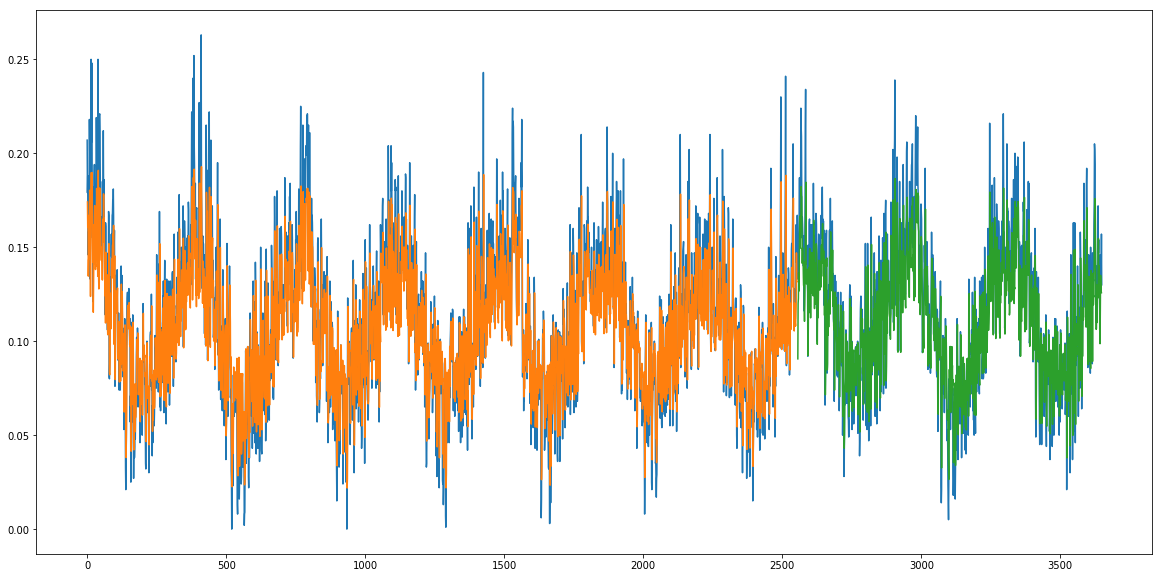

In [219]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()